# Compute seismic events from simulation
This notebook shows the workflow to compute the seismic events of a simulation using the python function `extract_events`. For usage details of this function, check the source code in `qdyn/utils/postprocessing/extract_events`

In [1]:
# reload modules automatically
%load_ext autoreload
%autoreload 2

"""
INITIAL PARAMETERS
"""
import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt

# Add QDYN source directory to PATH
# Go up in the directory tree
qdyn_dir = "/home/crodriguezpiceda/qdyn_intel_openmp/qdyn"

# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn")
)

# Append src directory to Python path
sys.path.append(src_dir)
# Get QDYN post_processing library directory
post_processing_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn", "utils", "post_processing")
)
# Append post_processing library directory to Python path
sys.path.append(post_processing_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year

# Instantiate the QDYN class object
p = qdyn()


First we need to read the mesh_dict, set_dict and the outputs ot, ot_fault and ot_vmax

In [3]:
# Read meshdict and set dict (needed for reading the outputs afterwards)
directory = sys.path[0]

path_dict=os.path.join(directory,"meshdict.pkl")
dict_to_read = open(path_dict, "rb")

# assign dictionary to p.mesh_dict
p.mesh_dict = pickle.load(dict_to_read)


path_dict=os.path.join(directory,"setdict.pkl")
dict_to_read = open(path_dict, "rb")

# assign dictionary to p.mesh_dict
p.set_dict = pickle.load(dict_to_read)

# read output 
p.read_output(read_ot=True, filename_ot = "output_ot", read_fault=True)

True

Compute events from the simulation output

In [18]:
# import function to extract events
from extract_events import extract_events

# extract events
model_dict = compute_events(p.set_dict, p.mesh_dict, p.ot, p.fault, p.ot_vmax)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The information per fault can be accesed by using the "fault label" as key

In [23]:
# DataFrame corresponding to event of Fault 1
model_dict["ev"][1]

,min_t,max_t,cum_slip,cum_potency,peak_v,dt_event,t_event,t_interevent_intrafault,Mw,fault_label
n_event,,,,,,,,,,
1,7.626435e+08,7.626435e+08,0.033275,864404.0,1.425441,4.912560,7.626435e+08,NaN,4.882559,1
2,1.944194e+09,1.944194e+09,0.034351,892350.0,1.170373,9.937200,1.944194e+09,1.181551e+09,4.891771,1
3,3.183696e+09,3.183696e+09,0.029519,766817.0,1.007934,6.701400,3.183696e+09,1.239501e+09,4.847875,1
4,4.300368e+09,4.300368e+09,0.027651,718286.0,1.044646,16.507300,4.300368e+09,1.116672e+09,4.828946,1
5,5.104093e+09,5.104093e+09,0.002796,72621.0,0.705963,8.065801,5.104093e+09,8.037252e+08,4.165456,1
...,...,...,...,...,...,...,...,...,...,...
62,5.983282e+10,5.983282e+10,0.014052,365040.0,0.905055,5.041000,5.983282e+10,1.533864e+08,4.632974,1
63,6.086979e+10,6.086979e+10,0.038934,1011410.0,0.494586,7.556000,6.086979e+10,1.036967e+09,4.928032,1
64,6.161977e+10,6.161977e+10,0.012588,327010.0,0.966318,6.543999,6.161977e+10,7.499804e+08,4.601122,1


We can plot the results of slip, peak slip rate, event duration, recurrence interval within fault, Mw, and recurrence interval between faults

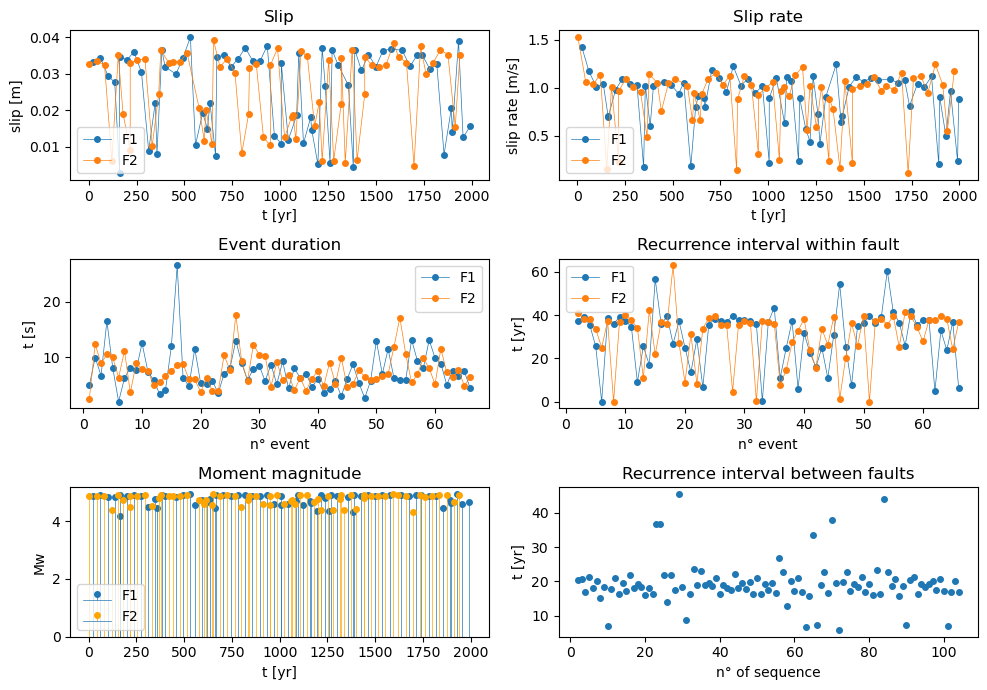

In [20]:
# plot event information
plt.close("all")

# Set the rc parameters for marker size and linewidth
plt.rc('lines', markersize=4, linewidth=0.5)

# create canvas
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), squeeze=False)

# Append suffix / prefix to strings in list label models

# Labels
lbl1 = "F1"
lbl2 = "F2"

# Relevant Dataframes
df_ev1 = model_dict["ev"][1] # DataFrame with events of Fault 1
df_ev2 = model_dict["ev"][2] # DataFrame with events of Fault 2
df_seq = model_dict["seq"]["1_2"] # DataFrame with interevent time between faults


## Plot quantities
#Slip
ax[0,0].plot(df_ev1["t_event"]/t_yr, df_ev1["cum_slip"], label = lbl1, marker="o")
ax[0,0].plot(df_ev2["t_event"]/t_yr, df_ev2["cum_slip"], label = lbl2, marker="o")
ax[0,0].set_xlabel("t [yr]")
ax[0,0].set_ylabel("slip [m]")
ax[0,0].legend()
ax[0,0].set_title("Slip")

# Peak slip rate
ax[0,1].plot(df_ev1["t_event"]/t_yr, df_ev1["peak_v"], label = lbl1, marker="o")
ax[0,1].plot(df_ev2["t_event"]/t_yr, df_ev2["peak_v"], label = lbl2, marker="o")
ax[0,1].set_xlabel("t [yr]")
ax[0,1].set_ylabel("slip rate [m/s]")
ax[0,1].legend()
ax[0,1].set_title("Slip rate")

# Event duration
ax[1,0].plot(df_ev1.index, df_ev1["dt_event"], label = lbl1, marker="o")
ax[1,0].plot(df_ev2.index, df_ev2["dt_event"], label = lbl2, marker="o")
ax[1,0].set_xlabel("n° event")
ax[1,0].set_ylabel("t [s]")
ax[1,0].legend()
ax[1,0].set_title("Event duration")

# Recurrence interval within fault
ax[1,1].plot(df_ev1.index, df_ev1["t_interevent_intrafault"]/t_yr, label = lbl1, marker="o")
ax[1,1].plot(df_ev2.index, df_ev2["t_interevent_intrafault"]/t_yr, label = lbl2, marker="o")
ax[1,1].set_xlabel("n° event")
ax[1,1].set_ylabel("t [yr]")
ax[1,1].legend()
ax[1,1].set_title("Recurrence interval within fault")

# Moment magnitude
markerline1, stemlines1, baseline1 = ax[2,0].stem(df_ev1["t_event"]/t_yr,df_ev1["Mw"], linefmt="#1f77b4",label = "F1", markerfmt='o', basefmt= 'C0')
plt.setp(stemlines1, 'color', plt.getp(markerline1,'color'))
markerline2, stemlines2, baseline2 = ax[2,0].stem(df_ev2["t_event"]/t_yr,df_ev2["Mw"], linefmt="orange",label = "F2", markerfmt='o', basefmt= 'C0')
plt.setp(stemlines2, 'color', plt.getp(markerline2,'color'))
ax[2,0].set_ylim(bottom=0)
ax[2,0].set_xlabel("t [yr]")
ax[2,0].set_ylabel("Mw")
ax[2,0].legend()
ax[2,0].set_title("Moment magnitude")

# Recurrence interval between faults
ax[2,1].scatter(df_seq.index, df_seq["t_interevent_interfault"]/t_yr, marker="o")
ax[2,1].set_xlabel("n° of sequence")
ax[2,1].set_ylabel("t [yr]")
ax[2,1].set_title("Recurrence interval between faults")



fig.tight_layout()       
plt.show()

Next we can extract the location of nucleation points and its spatial frequency

In [65]:
# reload modules automatically
%load_ext autoreload
%autoreload 2

# import function to extract events
from nucleation_point import nucleation_point

# Add to model_dict the information about nucleation points
model_dict_np = nucleation_point(p.mesh_dict, model_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The information of the location point is stored in `model_dict_np["np"][<fault_label>]`. This includes: index (n event), step (timestep of nucleation), ivmax (index of element with peak velocity at nucleation), v (nucleation velocity), theta, tau, dtau_dt, slip (cumulative slip from start of simualtion), sigma, fault_label, deltat (time duration of event), n_event, and coordinates x y z of nucleation point. 

The information of the location point frequency is stored in `model_dict_np["count_np"][<fault_label>]`. This includes: coordinates x y z, fault_label and count_np (absolute frequency)

In [67]:
# print information of location point for Fault 1
print(model_dict_np["np"][1])

# print information of location point frequency for Fault 1
print(model_dict_np["count_np"][1])

            step             t  ivmax         v      theta         tau  \
n_event                                                                  
1           7220  7.626435e+08  13087  0.011000   1.535125  12757290.0   
2          45850  1.944194e+09  11822  0.012146   3.382333  13070470.0   
3          86140  3.183696e+09  12319  0.010183   2.422698  12900680.0   
4         126040  4.300368e+09  13613  0.011796   1.769490  12813140.0   
5         152590  5.104093e+09  11986  0.010986   3.205317  13008990.0   
...          ...           ...    ...       ...        ...         ...   
62       2031810  5.983282e+10  13272  0.010229   1.045018  12609150.0   
63       2065780  6.086979e+10  14127  0.011722   2.651102  12947060.0   
64       2090200  6.161977e+10  14292  0.012924  13.807510  13544470.0   
65       2129760  6.278288e+10  11731  0.010299  12.039710  13495130.0   
66       2141150  6.297385e+10  14126  0.011029   0.615951  12433040.0   

         dtau_dt      slip       sigm